In [ ]:
# 模拟生成时间序列
#模拟生成数据集
#搭建两个RNN神经网络，一个使用LR_scheduler机制调整学习率，另一个不做处理

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

In [ ]:
%config IPCompleter.greedy=True

In [3]:
def plot_series(time,series,format="-",start=0,end=None):
    plt.plot(time[start:end],series[start:end],format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time,slope=0):=[]
    return slope*time

def seasonal_pattern(season_time):
    return np.where(season_time<0.4,np.cos(season_time*2*np.pi),1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time=((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

def noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

time = np.arange(4*365+1,dtype="float32")
baseline = 10
series = trend(time,0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)

series+= noise(time,noise_level,seed=42)

split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

window_size=20
batch_size=32
shuffle_buffer_size=1000


In [4]:

def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window:window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1],window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [12]:

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train,window_size,batch_size=128,shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=-1),
                          input_shape=[None]),
    tf.keras.layers.SimpleRNN(40,return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
            optimizer=optimizer,
            metrics=['mae'])
#model.compile(loss='mse', optimizer='adam', metrics=[, 'cosine'])

history=model.fit(train_set,epochs=100,callbacks=[lr_schedule])


Epoch 1/100
8/8 [==============================] - 1s 7ms/step - loss: 194.6263 - mae: 195.1263
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 195.2579 - mae: 195.7579
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 193.9793 - mae: 194.4793
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 192.3059 - mae: 192.8059
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 189.4673 - mae: 189.9673
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 187.5113 - mae: 188.0113
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 185.2976 - mae: 185.7976
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 183.4113 - mae: 183.9113
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 180.7795 - mae: 181.2795
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 176.5625 - mae: 177.0625
Epoch 11/100
8/8 [=====================

{'loss': [195.57260131835938, 194.78195190429688, 193.5109405517578, 191.90806579589844, 190.02346801757812, 187.85824584960938, 185.37864685058594, 182.54832458496094, 179.31260681152344, 175.6016845703125, 171.3243408203125, 166.35214233398438, 160.5517120361328, 153.6377716064453, 145.3260955810547, 135.03509521484375, 121.99201965332031, 105.34258270263672, 84.12541961669922, 57.27104949951172, 32.032291412353516, 24.301284790039062, 23.348979949951172, 21.113557815551758, 17.127229690551758, 13.847335815429688, 10.77497386932373, 8.765877723693848, 7.978348731994629, 7.882411003112793, 7.842448711395264, 7.729313373565674, 7.689589977264404, 7.585262775421143, 7.517235279083252, 7.407004356384277, 7.348042011260986, 7.293787479400635, 7.2490644454956055, 7.226044178009033, 7.284417629241943, 7.452866077423096, 7.158520698547363, 7.143613815307617, 7.056920528411865, 6.932894229888916, 6.745328426361084, 7.452260494232178, 7.281428337097168, 6.914649486541748, 7.054927349090576, 7.

(1e-08, 0.0001, 0.0, 30.0)

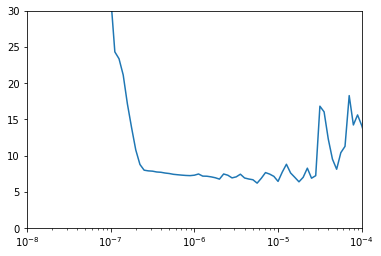

In [13]:
print(history.history)
plt.semilogx(history.history["lr"],history.history["loss"])
plt.axis([1e-8,1e-4,0,30])

In [15]:
# 搭建simpleRNN神经网络，不调整学习率
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train,window_size,batch_size=128,shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=-1),
                          input_shape=[None]),
    tf.keras.layers.SimpleRNN(40,return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*100.0)
])


optimizer = tf.keras.optimizers.SGD(lr=7e-5,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
            optimizer=optimizer,
            metrics=['mae'])
history=model.fit(train_set,epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 8ms/step - loss: 123.4734 - mae: 123.9722
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 33.4390 - mae: 33.9371
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 20.2484 - mae: 20.7453
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 15.4888 - mae: 15.9823
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 19.9918 - mae: 20.4902
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 14.7777 - mae: 15.2726
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 9.9064 - mae: 10.3978
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 8.7024 - mae: 9.1837
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 18.7240 - mae: 19.2215
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 13.6815 - mae: 14.1735
Epoch 11/100
8/8 [==============================] - 0s 5ms/s

[69.295685 71.697845 72.063545 70.318565 67.433624 68.73299  68.91431
 70.85057  71.45278  72.32779  68.00737  71.254196 69.95238  73.48787
 68.38755  71.96201  70.288795 66.46174  66.19882  65.590805 67.201035
 68.87886  66.75346  67.03578  72.1412   74.61112  72.6797   71.00003
 69.65903  70.338104 66.176384 66.491264 62.79803  64.89464  68.28682
 66.31488  71.46701  66.04068  62.392025 65.802734 69.02372  73.263306
 69.46688  72.10922  69.65719  68.21426  71.33108  71.65437  65.230095
 70.04243  72.89008  67.87419  70.33231  70.83273  69.986435 67.827576
 66.73019  67.14771  70.553    71.35319  69.21951  71.303085 63.170387
 67.715225 63.955124 64.24038  63.940735 61.86263  67.62786  66.52839
 68.82974  69.208496 70.34197  70.04271  66.09076  69.89557  67.82239
 63.64963  65.59896  70.13475  71.982414 69.95291  69.5067   68.160515
 72.98741  72.56486  72.90683  74.3556   72.447685 70.517296 70.06938
 69.66049  69.5005   71.87739  71.12593  72.70076  78.16658  81.65496
 83.46379  84.

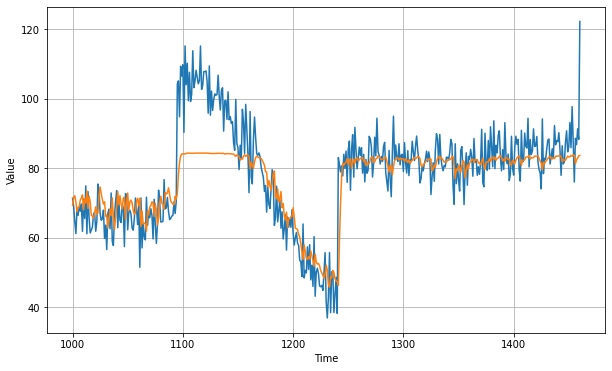

In [22]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]
print(results)

plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid,results).numpy()

6.454768

<Figure size 432x288 with 0 Axes>

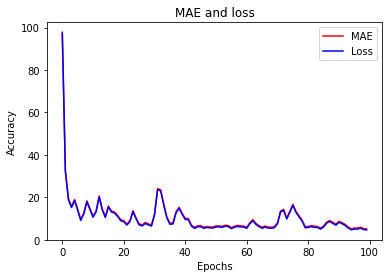

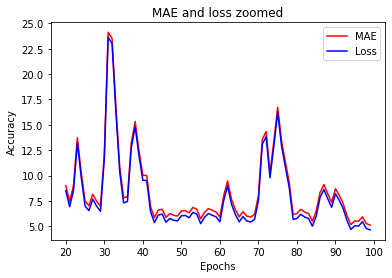

<Figure size 432x288 with 0 Axes>

In [21]:
#训练集和测试集上获取结果列表
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Retrieve a list of list results on training and test data
# sets for each tarining epoch

mae=history.history['mae']
loss=history.history['loss']
epochs=range(len(loss)) 

#Plot MAE and loss

plt.plot(epochs,mae,'r')
plt.plot(epochs,loss,'b')
plt.title('MAE and loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE","Loss"])

plt.figure()

epochs_zoom = epochs[20:]
mae_zoom = mae[20:]
loss_zoom = loss[20:]

#Plot Zoomed MAE and loss

plt.plot(epochs_zoom,mae_zoom,'r')
plt.plot(epochs_zoom,loss_zoom,'b')
plt.title('MAE and loss zoomed')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE","Loss"])

plt.figure()
